# Star-forming, Quiescent and Dusty Galaxy Spectral Energy Distributions
This code uses the UVJ diagram to seperate Michael Brown's Galaxy SED templates. Using the templates,
these are used with astSED to calculate the photometric colours. These photometric colours are plotted, and
then are used to categorize the galaxy into a particular type

In [84]:
# Import any and all relevant libraries into the workspace
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
#from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath

In [85]:
# Import templates + filters for astSED

# Brown templates
brown_folderpath = os.path.join('datasets', 'Templates', 'Brown', '2014','Rest')

# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')

In [86]:
# Load the filters into astSED
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)

In [118]:
def read_brown_galaxy_templates(folder_path):
    """_summary_

        Args:
            folder_path (string): path to the folder where the SED templates are located
    
        Returns:
            df_list: Returns a list of dataframes containing the SED templates
            objname_list: Returns a list of the names of the objects
    """
    df_list = []
    objname_list = []
    folder_path = os.path.join(folder_path)
    files_in_folder = os.listdir(folder_path)
    for file in files_in_folder:

        # Find filepath and convert to df
        objname = file.split('_restframe.dat')[0]
        filepath = os.path.join(folder_path, file)
        data = np.loadtxt(filepath)
        df = pd.DataFrame(data)
            
        # our wavelength is in microns, convert to Angstroms
        df[0] = df[0] * 10000 # microns 10^-6 -> Angstroms 10^-10 
        
        # Name each of the columns appropriately
        df.columns = ['lambda (Angstroms)', 'Luminosity (W/Hz)' , 'Total Flux (erg/s/cm^2/Angstrom)', 'Source']
            
        # Append the dataframe to the list    
        df_list.append(df)
        objname_list.append(objname)
        
        
    return (df_list, objname_list)

In [87]:
# Read all of the galaxies into the workspace
galaxy_seds, names = read_brown_galaxy_templates(brown_folderpath)

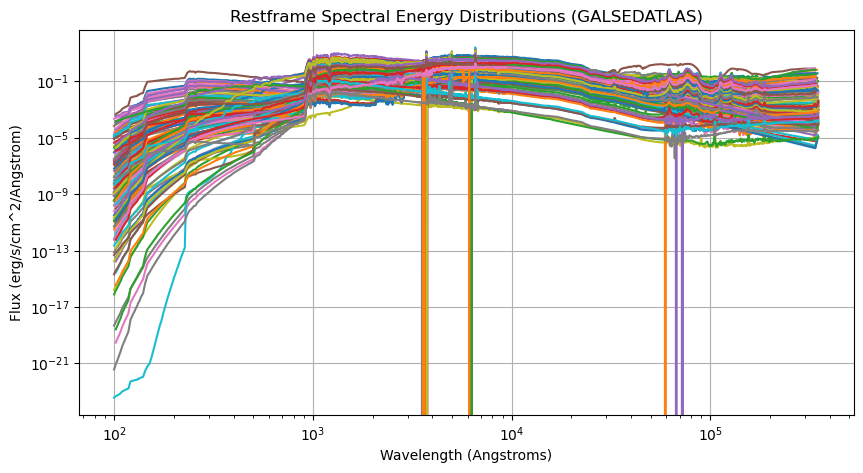

In [88]:
# Plot these galaxies
plt.figure(figsize=(10, 5))
for i, template in enumerate(galaxy_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=names[i])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Restframe Spectral Energy Distributions (GALSEDATLAS)')
plt.grid()
plt.show()

So above we see the spectral energy distributions of the GALSEDATLAS templates which are clearly restframed, owining to the fact that the lyman break, and emission lines are all in the same position.

In [89]:
uv_list = []
vj_list = []

# Calculate the colours, and subsequently derive the uvj positions: classifying each position depending on it's location within UVJ space
for i in range(len(galaxy_seds)):
        wl = galaxy_seds[i].iloc[:, 0].values
        fl = galaxy_seds[i].iloc[:, 2].values
        sed = astSED.SED(wavelength=wl, flux=fl, z=0) # z = 0.0 as these are restframe SEDs
        uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
        vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
        uv_list.append(uv)
        vj_list.append(vj)

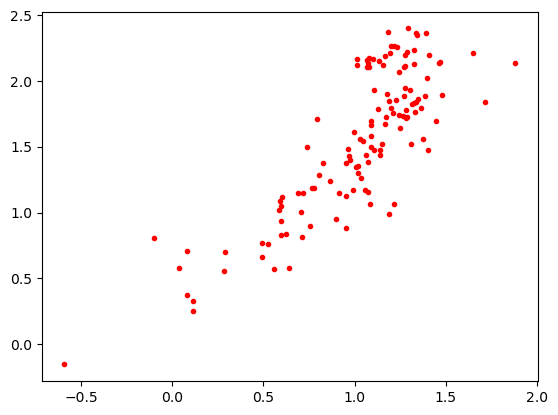

In [90]:
uv_list
vj_list


plt.plot(vj_list, uv_list, 'r.')
plt.show()

In [91]:
# Create a new dataframe with these colours inside, using the names array as the id
galaxy_seds_df = pd.DataFrame(names)

In [92]:
galaxy_seds_df = galaxy_seds_df.rename(columns={0:'id'})

In [93]:
galaxy_seds_df

,id
0,Arp_118
1,Arp_256_N
2,Arp_256_S
3,CGCG_049-057
4,CGCG_436-030
...,...
123,UGC_09618_N
124,UGC_09618
125,UGC_09618_S
126,UGC_12150


In [94]:
# Adding galaxy colours
galaxy_seds_df['uv'] = uv_list
galaxy_seds_df['vj'] = vj_list

               id        uv        vj
0         Arp_118  1.933255  1.301545
3    CGCG_049-057  2.138991  1.460834
5    CGCG_453-062  1.729835  1.171640
8         IC_0860  1.932362  1.107464
10        IC_4051  2.373791  1.184062
..            ...       ...       ...
105      NGC_7591  1.734840  1.263813
111      NGC_7771  1.883655  1.387100
116     UGC_04881  1.672016  1.165898
117     UGC_05101  1.716574  1.281578
126     UGC_12150  2.146826  1.465444

[68 rows x 3 columns]


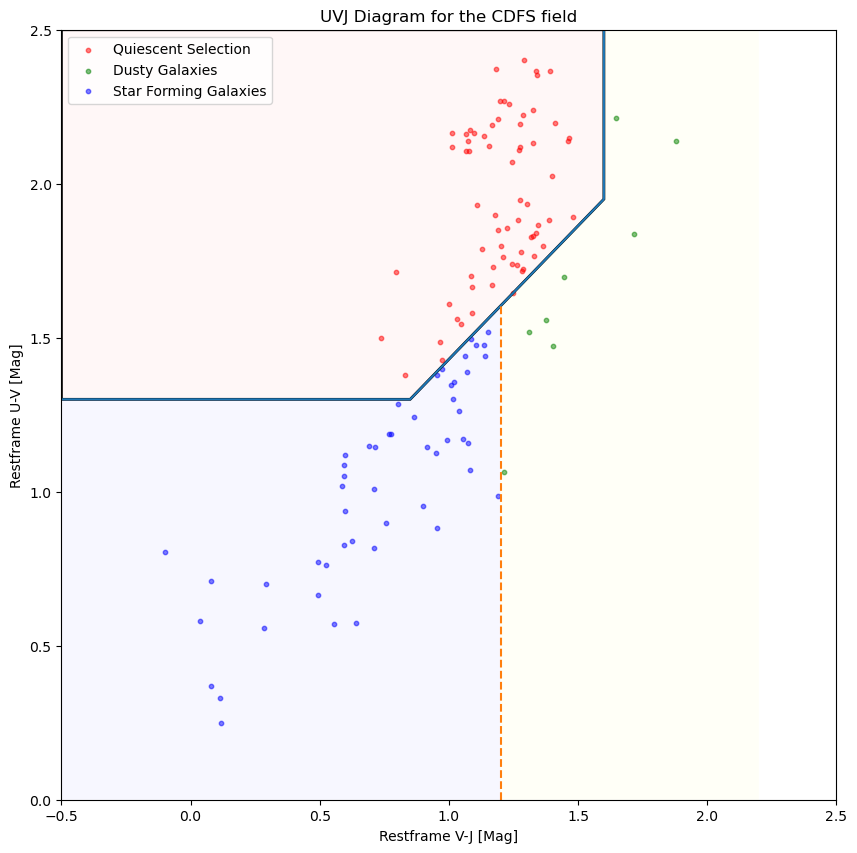

In [95]:
# We can also create a new column which will contain the category. Importantly the index will stay the same
# allowing us to grab the index and pull the sed from the list. Creating the UVJ colours 
df = galaxy_seds_df

# Plot the UVJ diagram
plt.figure(figsize=(10, 10))

x = df['vj']
y = df['uv']
id = df['id']

xmax = 2.5
ymax = 2.5
xmin = -0.5
ymin = 0

# Set the plotting limits
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Define the points for a quiescent galaxy selection
x_points = [-0.5, 0.85, 1.6, 1.6]
y_points = [1.3, 1.3, 1.95, 2.5]

# Plot the points
plt.plot(x_points, y_points, linestyle='-')

# Interpolate the y-value at x=1.2
x_target = 1.2
y_target = np.interp(x_target, x_points, y_points)

# Plot the interpolated point, this separates everything on the right as dusty galaxies,
# and everything on the left as star-forming galaxies
plt.plot([x_target, x_target], [0, y_target], linestyle='--')

quiescent_x = [-0.5, 0.85, 1.6, 1.6, xmin, xmin]
quiescent_y = [1.3, 1.3, 1.95, 2.5, ymax, 1.3]
# We want to make a wedge selection for the Quiescent Selection of Galaxies
points = np.column_stack([x, y])
verts = np.array([quiescent_x, quiescent_y]).T
path = mpath.Path(verts)


# Define the path for point selection
#selected_path = mpath.Path([(2, 3), (6, 4), (8, 2), (2, 1), (2, 3)])  # Example path, replace with your own

# Use path.contains_points to get a boolean array
points_inside_selection = path.contains_points(np.column_stack([x, y]))



dusty_condition = (points[:, 0] > x_target) & (~points_inside_selection)
star_forming_condition = (points[:, 0] < x_target) & (~points_inside_selection)



# Filter the DataFrame using the boolean array
selected_df = df[points_inside_selection] # For quiescent, clean later

# Mark dusty, and star-forming galaxies
df.loc[dusty_condition, 'GalaxyType'] = 2
df.loc[star_forming_condition, 'GalaxyType'] = 1





# Now we can easily select the quiescent galaxies and set the galaxy type to quiescent - 0 or starforming 1.
print(selected_df)
selected_ids = selected_df['id']
df.loc[df['id'].isin(selected_ids), 'GalaxyType'] = 0 # This is what makes the selection happen



# Try do the same for the unselected galaxies, noting that the unselected galaxies with x and y > 1.2 are dusty galaxies, and the rest are star-forming galaxies
#unselected_ids = unselected_df['id']




# Sort the quiescent and non-quiescent galaxies
quiescent_points = points[path.contains_points(points)]
# Find the points from here to categorise dusty, and star-forming galaxies
non_quiescent_points = points[~path.contains_points(points)]
dusty_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] > x_target]
star_forming_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] < x_target]


#print(non_quiescent_points[0][0])

#print(y)
# Plot the selected points
#plt.scatter(x, y, s=3, alpha=0.5, label='Not Quiescent Selection')
plt.scatter(quiescent_points[:, 0], quiescent_points[:, 1], c='r', s=10, alpha=0.5, label='Quiescent Selection')
plt.scatter(dusty_galaxies_points[:, 0], dusty_galaxies_points[:, 1], c='g', s=10, alpha=0.5, label='Dusty Galaxies')
plt.scatter(star_forming_galaxies_points[:, 0], star_forming_galaxies_points[:, 1], c='b', s=10, alpha=0.5, label='Star Forming Galaxies')

# Plot the names for the selected galaxies, in each reigon
# text = []
# for i in range(len(df)):
#    text.append(plt.text(df.iloc[i]['VJ'], df.iloc[i]['UV'], df.iloc[i]['ID']))
# adjust_text(text)


# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))


plt.xlabel('Restframe V-J [Mag]')
plt.ylabel('Restframe U-V [Mag]')
plt.title('UVJ Diagram for the CDFS field')
plt.legend()
plt.show()



We have now successfully classified our galaxies into Star-forming, Quiescent and Dusty Galaxies. Using this we can pull a selection of different SED types out, exploring these and seeing how they differ across different populations. In general we expect different behaviours for each. To make this more robust we can explore ZFOURGE templates to see the relative differnce in shape. Check these against the GALSEDATLAS paper from Michael Brown.

In [96]:
# Quiescent - 0
# Starforming - 1
# Dusty - 2


# Sample three seperate galaxies from each category, and plot their position in UVJ space
quiescent_galaxies = df[df['GalaxyType'] == 0]
star_forming_galaxies = df[df['GalaxyType'] == 1]
dusty_galaxies = df[df['GalaxyType'] == 2]


In [97]:
# sample n galaxies from each
n=1
quiescent_sample = quiescent_galaxies.sample(n)
star_forming_sample = star_forming_galaxies.sample(n)
dusty_sample = dusty_galaxies.sample(n)

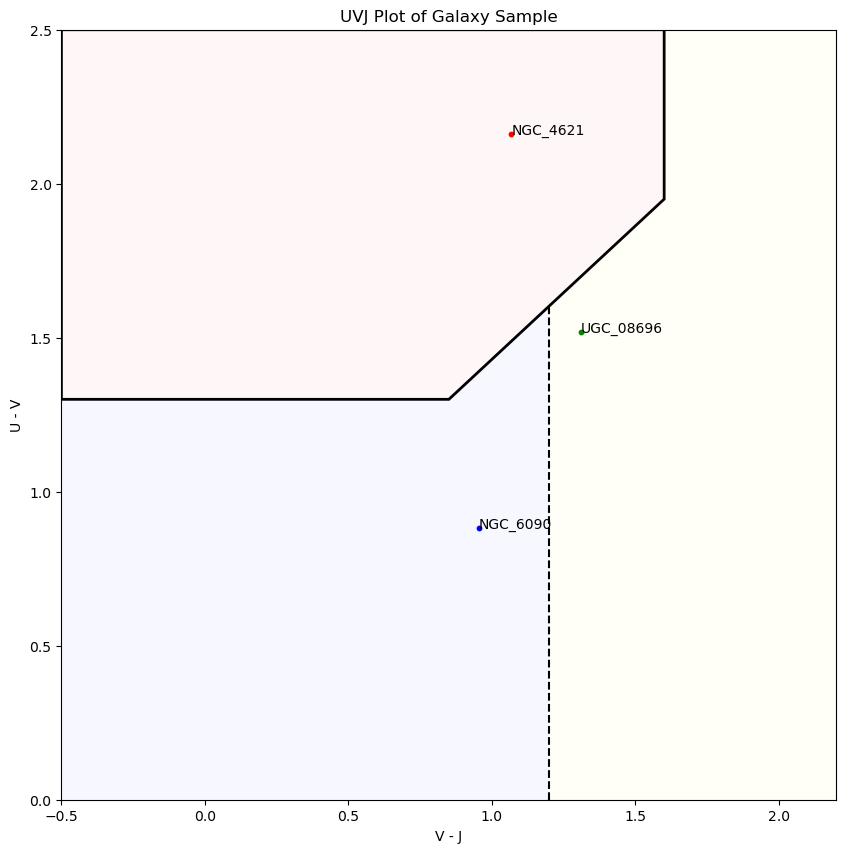

In [114]:
# Plot the Sample in UVJ
plt.figure(figsize=(10, 10))

plt.scatter(quiescent_sample['vj'],quiescent_sample['uv'], c='r', s=10)
plt.scatter(star_forming_sample['vj'],star_forming_sample['uv'], c='b', s=10)
plt.scatter(dusty_sample['vj'],dusty_sample['uv'], c='g', s=10)
annotations = []

# Annotate points with text and adjust for collisions
for i in range(len(quiescent_sample)):
    annotations.append(plt.text(quiescent_sample.iloc[i]['vj'], quiescent_sample.iloc[i]['uv'], quiescent_sample.iloc[i]['id']))
for i in range(len(star_forming_sample)):
    annotations.append(plt.text(star_forming_sample.iloc[i]['vj'], star_forming_sample.iloc[i]['uv'], star_forming_sample.iloc[i]['id']))
for i in range(len(dusty_sample)):
    annotations.append(plt.text(dusty_sample.iloc[i]['vj'], dusty_sample.iloc[i]['uv'], dusty_sample.iloc[i]['id']))

plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("UVJ Plot of Galaxy Sample")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])

# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# output the plot, and save it
plt.savefig('outputs/UVJPlotsGalaxySEDSampling.png')

plt.show()


In [101]:
# Now we can show the relevant SEDs
quiescent_seds = []
star_forming_seds = []
dusty_seds = []

for i in range(len(quiescent_sample)):
    quiescent_seds.append(galaxy_seds[names.index(quiescent_sample.iloc[i]['id'])])
for i in range(len(star_forming_sample)):
    star_forming_seds.append(galaxy_seds[names.index(star_forming_sample.iloc[i]['id'])])
for i in range(len(dusty_sample)):
    dusty_seds.append(galaxy_seds[names.index(dusty_sample.iloc[i]['id'])])

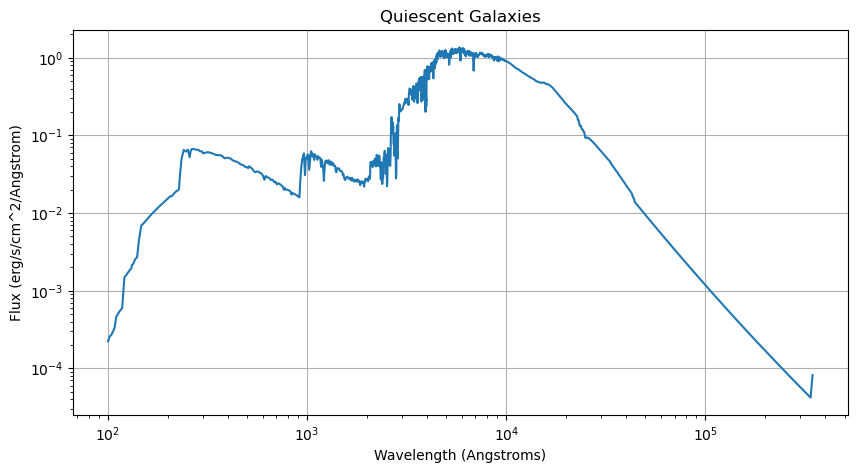

In [102]:
# Creating an SED plot for each
plt.figure(figsize=(10, 5))
for i, template in enumerate(quiescent_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=quiescent_sample.iloc[i]['id'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Quiescent Galaxies')
plt.grid()
plt.show()

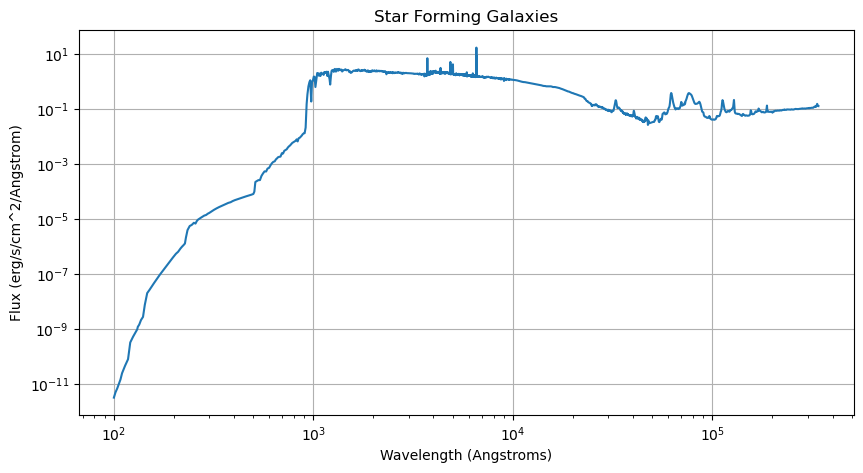

In [103]:
plt.figure(figsize=(10, 5))
for i, template in enumerate(star_forming_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=star_forming_sample.iloc[i]['id'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Star Forming Galaxies')
plt.grid()
plt.show()


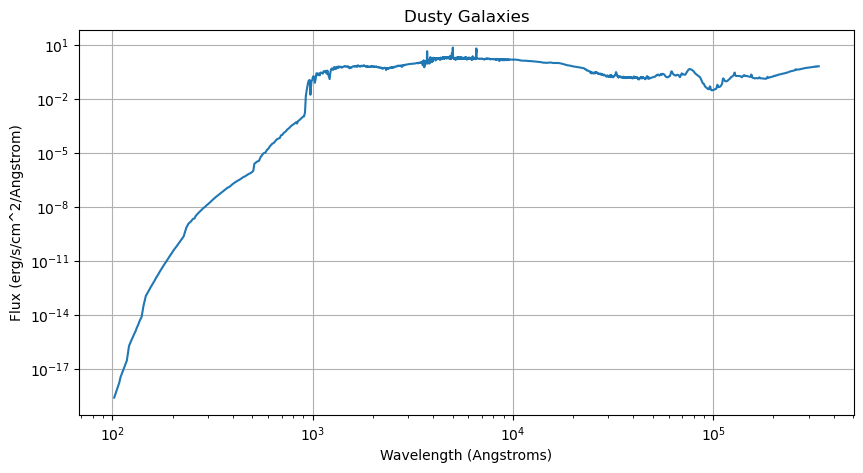

In [104]:
plt.figure(figsize=(10, 5))
for i, template in enumerate(dusty_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=dusty_sample.iloc[i]['id'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Dusty Galaxies')
plt.grid()
plt.show()


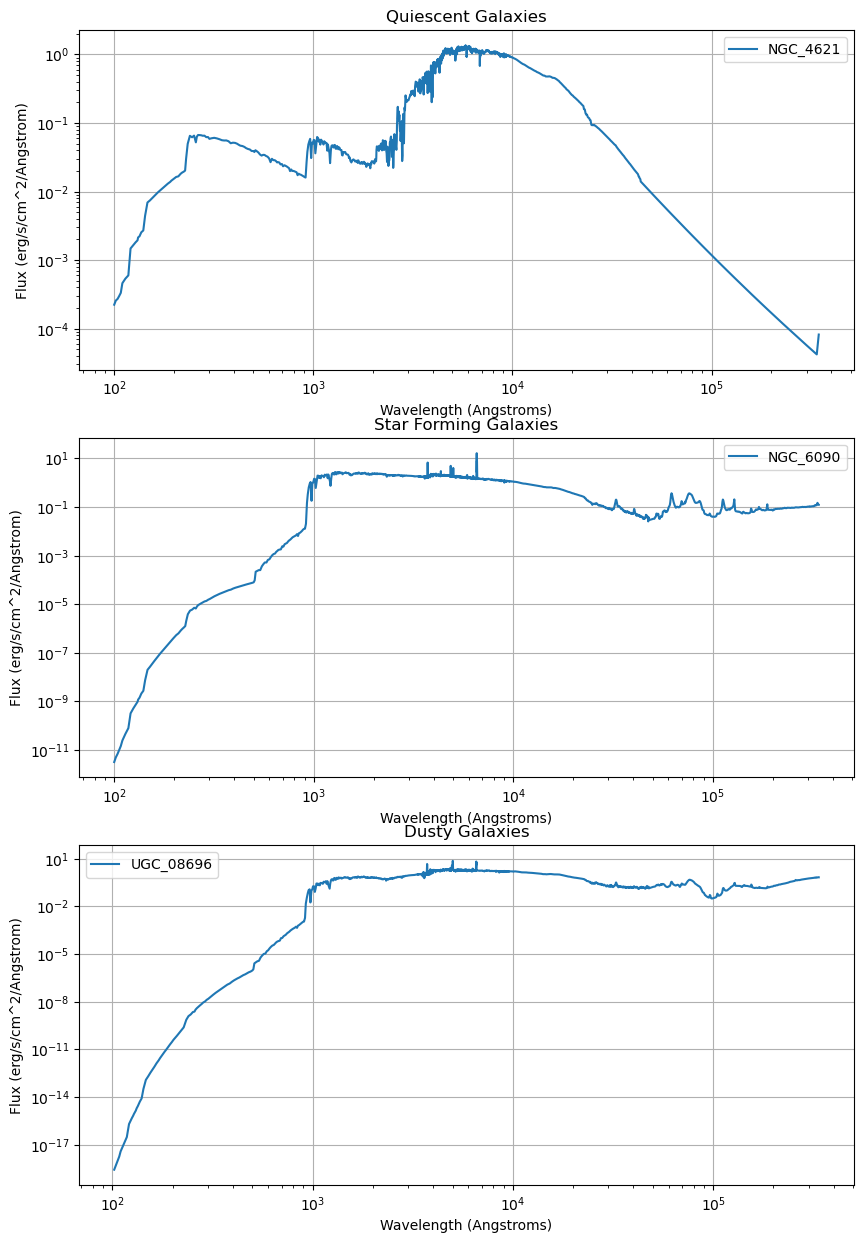

In [113]:
# Create a grid of plots for each of the galaxy groupings
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, template in enumerate(quiescent_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    axs[0].loglog(wl, fl, label=quiescent_sample.iloc[i]['id'])
axs[0].set_xlabel('Wavelength (Angstroms)')
axs[0].set_ylabel('Flux (erg/s/cm^2/Angstrom)')
axs[0].set_title('Quiescent Galaxies')
axs[0].legend()
axs[0].grid()

for i, template in enumerate(star_forming_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    axs[1].loglog(wl, fl, label=star_forming_sample.iloc[i]['id'])
axs[1].set_xlabel('Wavelength (Angstroms)')
axs[1].set_ylabel('Flux (erg/s/cm^2/Angstrom)')
axs[1].set_title('Star Forming Galaxies')
axs[1].legend()
axs[1].grid()

for i, template in enumerate(dusty_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    axs[2].loglog(wl, fl, label=dusty_sample.iloc[i]['id'])
axs[2].set_xlabel('Wavelength (Angstroms)')
axs[2].set_ylabel('Flux (erg/s/cm^2/Angstrom)')
axs[2].set_title('Dusty Galaxies')
axs[2].legend()
axs[2].grid()


plt.savefig("outputs/Galaxy SEDs.png")
plt.show()

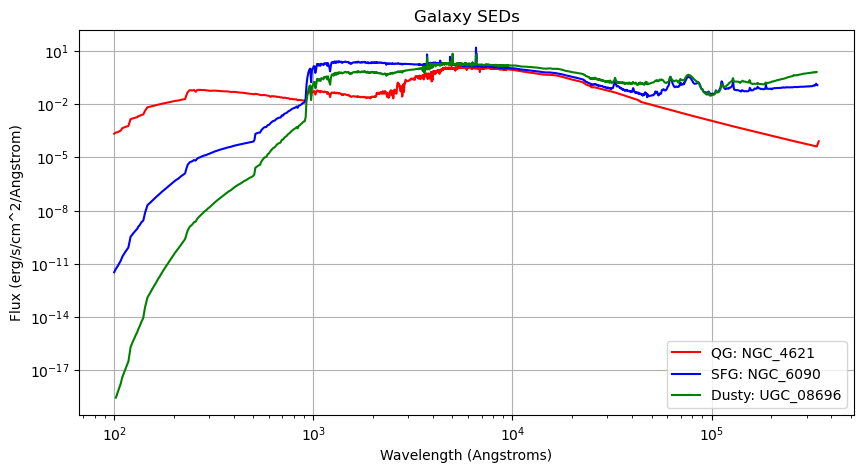

In [117]:
# Plot each galaxy sed on one plot
plt.figure(figsize=(10, 5))
for i, template in enumerate(quiescent_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label="QG: "+quiescent_sample.iloc[i]['id'], c='r')
for i, template in enumerate(star_forming_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label="SFG: " +star_forming_sample.iloc[i]['id'], c='b')
for i, template in enumerate(dusty_seds):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label="Dusty: "+dusty_sample.iloc[i]['id'], c='g')
    
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Galaxy SEDs')
plt.legend()
plt.grid()
plt.savefig("outputs/AllGalaxySEDs.png")